# Calculate residual topography

This notebook steps through the workflow that produces the pointwise residual topography estimates published in Stephenson _et_al._ (2024).

We use a very simple parametrisation that assumes constant mantle (asthenospheric) density.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.colors as colors
from SMV2rho import temperature_dependence as td
from SMV2rho import constants as c
from SMV2rho import uncertainties as unc


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Define a function to correct for crustal loading

Function in two components, density correction and thickness correcrtion.  We must have a file with crustal density and thickness estimates for each of our locations that we wish to correct.

In [2]:
def correction_simple(elev, t_cc, rho_cc, t_cr, rho_cr, rho_a):
    C_thickness = (t_cr - t_cc) * ((rho_a - rho_cr) / rho_a)
    C_density = t_cc * ((rho_cc - rho_cr) / rho_a)

    return {"thickness_correction": C_thickness,
            "density_correction": C_density,
            "residual_topography": elev + C_thickness + C_density}

### Set constants

Set the value of the reference crustal thickness and density, as well as asthenospheric density.  See Stephenson _et al._ (2024) for more details.

In [3]:
crust_file = "../INPUT_FILES/station_lon_lat_vp_vs_rho_topo_filt_lith_grav_all_onshore_ALL_T_DEPENDENT.dat"

t_cr = 32.1 # reference crustal thickness (km)
rho_cr = 2.84 # reference crustal density (g/cm^3)
rho_a = 3.25 # asthenospheric density (g/cm^3)

### Read data and calculate corrections and residual topo

First do some clearning.  Exclude extreme crustal thickness values beyond the reliability of the density conversion.  Exclude points that are dramatically below sea level.  Note this the density values in for data in this repository are calculated using `SMV2rho`, a scheme for converting crustal ceismic velocities to density.  It uses the `SeisCruST` database.  If using the density values or the crustal thickness values, then these repositories please refer to the useage guidance for these programs and databases.

In [4]:
crust_df = pd.read_csv(crust_file, delimiter=' ')

# exclude unreliable-looking densities (i.e. mantle densities)
#  and sediment densities)
# exclude unrealistically low points in topography
# and crust values outside reliable range
crust_df = crust_df.query("rho_c > 2.65")
crust_df = crust_df.query("rho_c < 3.15")
crust_df = crust_df.query("ETOPO_filt_30km > -0.2")
crust_df = crust_df.query("t_c > 15")
crust_df = crust_df.query("t_c < 50")

In [5]:
correction = correction_simple(
    crust_df["ETOPO_filt_30km"], 
    crust_df["t_c"], 
    crust_df["rho_c"], 
    t_cr, 
    rho_cr, 
    rho_a)

# Copy crust_df into res_topo_df
res_topo_df = crust_df.copy()

# Calculate corrections
correction = correction_simple(
    crust_df["ETOPO_filt_30km"], 
    crust_df["t_c"], 
    crust_df["rho_c"], 
    t_cr, 
    rho_cr, 
    rho_a)

# Add correction columns to res_topo_df
for column_name, data in correction.items():
    res_topo_df[column_name] = data

### Plot the relationships between the data fields

/Users/eart0518/opt/anaconda3/envs/res_topo_simple/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/eart0518/opt/anaconda3/envs/res_topo_simple/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/eart0518/opt/anaconda3/envs/res_topo_simple/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/eart0518/opt/anaconda3/envs/res_topo_simple/lib/python3.12/site-packages/seaborn/_ol

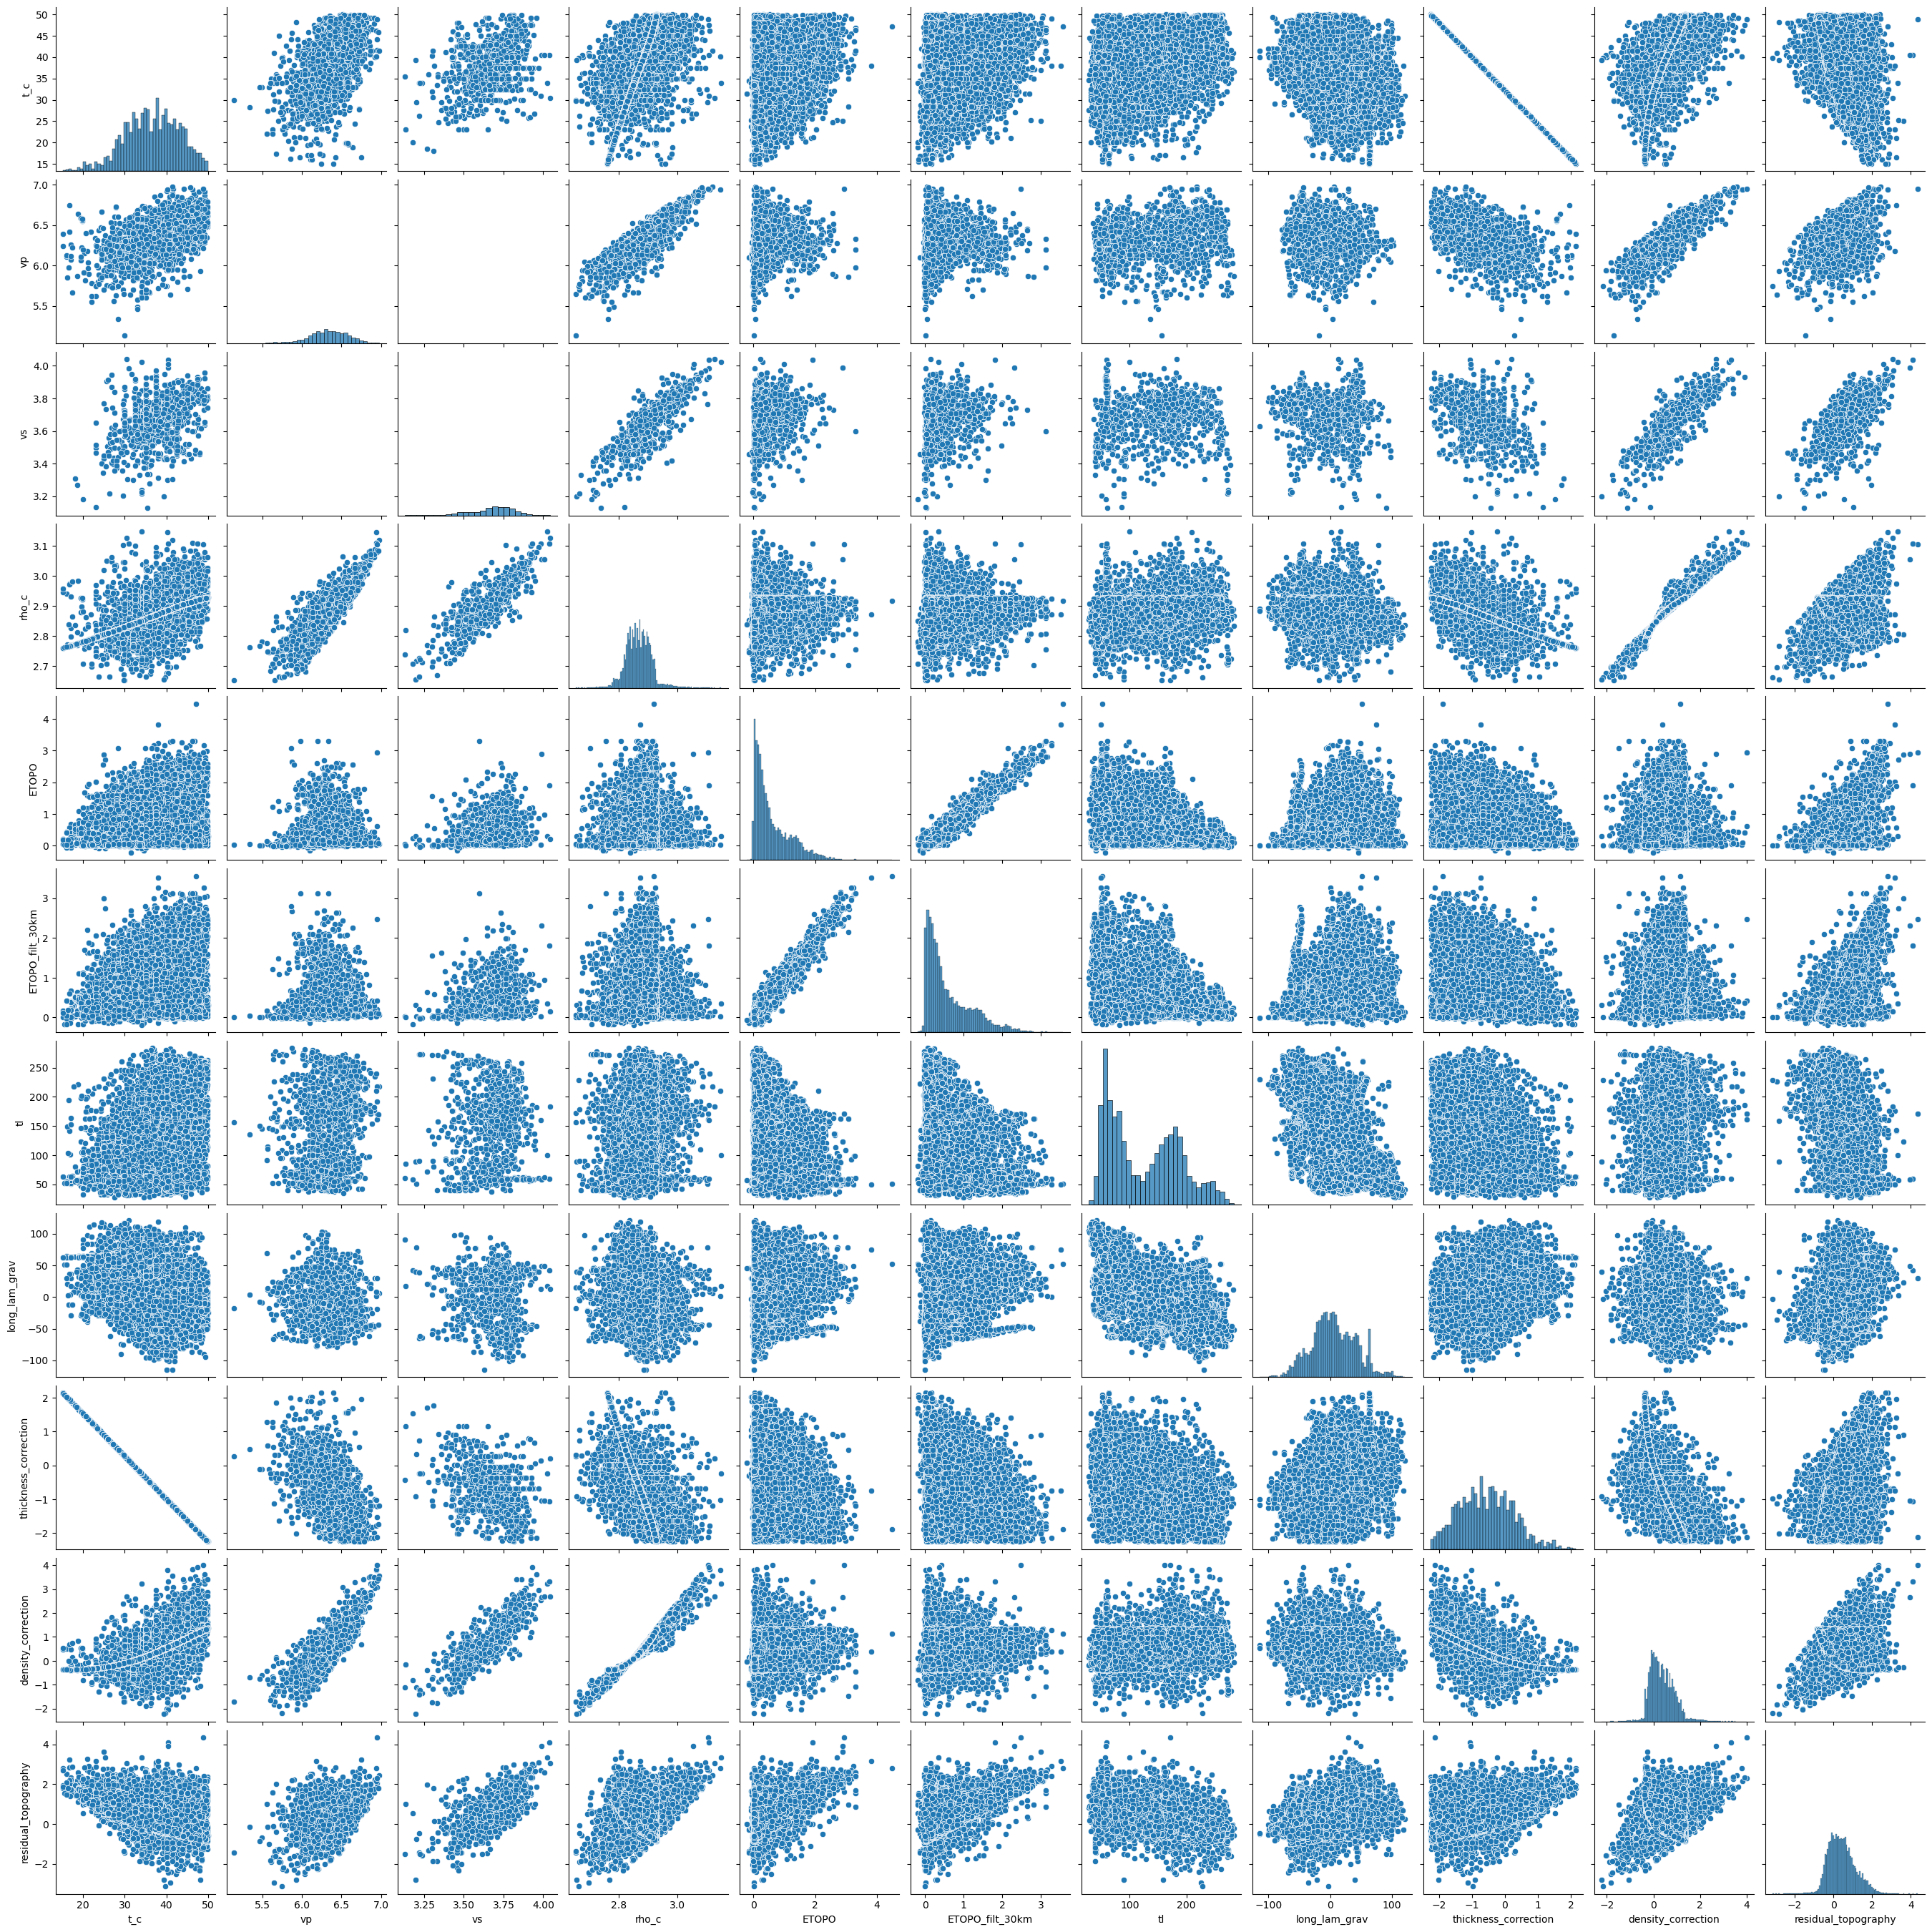

In [6]:
# Get a list of all column names
columns = res_topo_df.columns.tolist()

# Remove 'lon' and 'lat' from the list
columns.remove('lon')
columns.remove('lat')

# Create the pairplot with the selected columns
sns.pairplot(res_topo_df[columns])
plt.show()

### Outlier removal

We will now look more closely at the relationship between crustal thickness and residual topgraphy.  We will use this relationship to carry out some outlier removal

<Axes: xlabel='t_c', ylabel='residual_topography'>

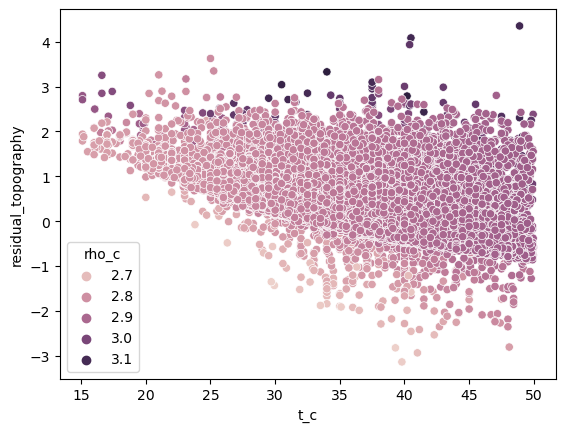

In [7]:
sns.scatterplot(res_topo_df, x='t_c', y='residual_topography', hue='rho_c')

Let's exclude some of the more obvious outliers by constructing a smooted moving standard deviation.  We will remove any datapoint that lies more than 3 stabndard deviations from the running mean.

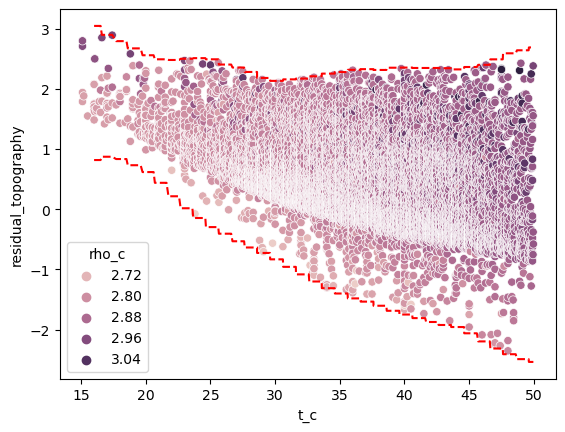

In [8]:
# Define the window size in terms of the x-variable
x_window_size = 1  # Adjust this value based on your specific needs

# Define the smoothing window size
smooth_window_size = 5  # Adjust this value based on your specific needs

# Sort the DataFrame by the x-variable
df_sorted = res_topo_df.sort_values('t_c')

# Initialize lists to store the results
rolling_mean = []
rolling_std = []
lower_bound = []
upper_bound = []
window_centers = []

# Loop over the range of the x-variable
for x in np.arange(df_sorted['t_c'].min(), df_sorted['t_c'].max(), x_window_size):
    # Select the subset of data within the current window
    window_data = df_sorted[(df_sorted['t_c'] >= x) & (df_sorted['t_c'] < x + x_window_size)]['residual_topography']
    
    # Calculate the mean and standard deviation for the current window
    mean = window_data.mean()
    std = window_data.std()
    
    # Define the lower and upper bounds for outlier detection
    multiplier = 3.0
    lower = mean - multiplier * std
    upper = mean + multiplier * std
    
    # Store the results
    rolling_mean.append(mean)
    rolling_std.append(std)
    lower_bound.append(lower)
    upper_bound.append(upper)
    window_centers.append(x + x_window_size / 2)

# Create a DataFrame with the results
df_rolling_stats = pd.DataFrame({
    't_c': window_centers,
    'mean': rolling_mean,
    'std': rolling_std,
    'lower_bound': lower_bound,
    'upper_bound': upper_bound
})

# Apply a moving average to smooth the upper and lower bounds
df_rolling_stats['lower_bound_smooth'] = df_rolling_stats['lower_bound'].rolling(smooth_window_size, min_periods=1, center=True).mean()
df_rolling_stats['upper_bound_smooth'] = df_rolling_stats['upper_bound'].rolling(smooth_window_size, min_periods=1, center=True).mean()

# Merge the rolling stats with the original DataFrame
df_merged = pd.merge_asof(df_sorted, df_rolling_stats, on='t_c')

# Identify outliers based on the smoothed bounds
outliers = (df_merged['residual_topography'] < df_merged['lower_bound_smooth']) | (df_merged['residual_topography'] > df_merged['upper_bound_smooth'])

# Remove outliers
res_topo_df_no_outliers = df_merged[~outliers]

# Create a scatter plot without outliers
sns.scatterplot(data=res_topo_df_no_outliers, x='t_c', y='residual_topography', hue='rho_c')

# Add the smoothed rolling window bounds to the plot
plt.plot(df_merged['t_c'], df_merged['upper_bound_smooth'], color='r', linestyle='--')
plt.plot(df_merged['t_c'], df_merged['lower_bound_smooth'], color='r', linestyle='--')

# Show the plot
plt.show()

Calculate the number of outliers removed

In [9]:
frac_outliers =  1 - len(res_topo_df_no_outliers) / len(res_topo_df)
print(f"fraction of database that are outliers: {round(frac_outliers * 100, 3)}%")

print(f"Number of outliers: {len(outliers[outliers == True])}")

fraction of database that are outliers: 0.991%
Number of outliers: 191


## Plotting

We will now plot the pointwis3 residual topography data on a global map.

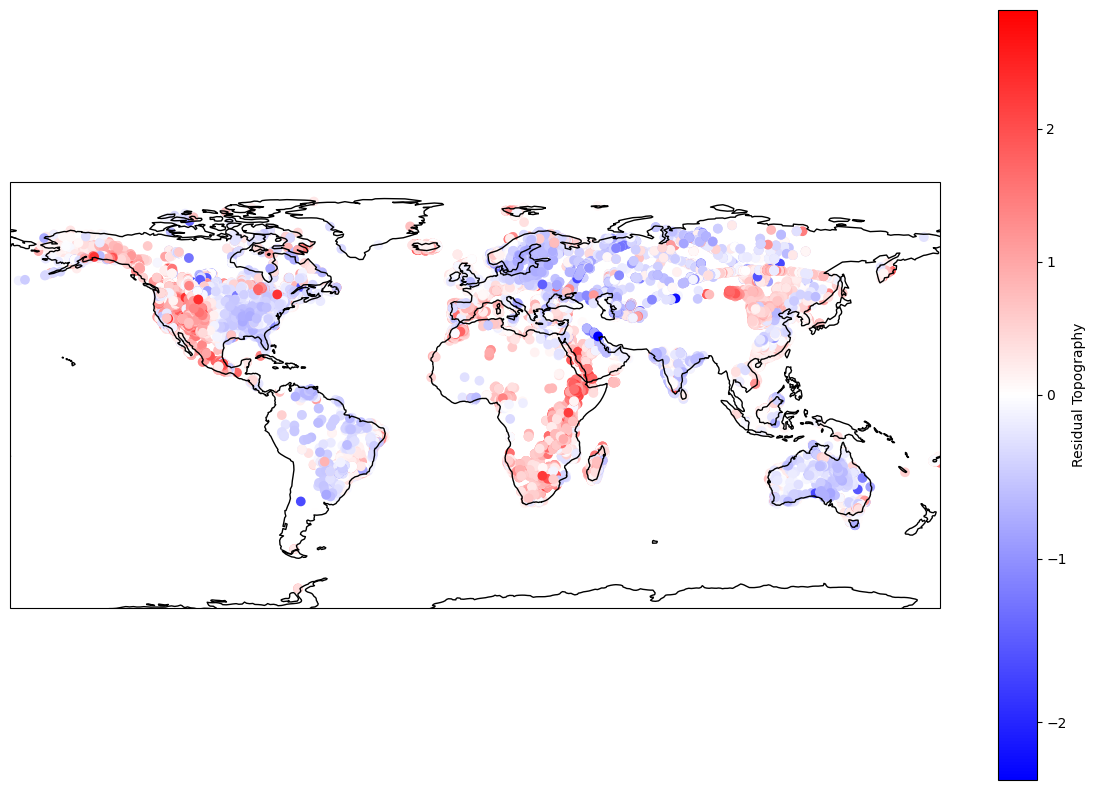

In [11]:
# Create a figure and a GeoAxes with a PlateCarree projection
fig = plt.figure(figsize=(15, 10))  # Increase the size here
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Create a TwoSlopeNorm with midpoint at 0
divnorm = colors.TwoSlopeNorm(vmin=res_topo_df_no_outliers['residual_topography'].min(), 
                              vcenter=0, 
                              vmax=res_topo_df_no_outliers['residual_topography'].max())

# Create a custom colormap with white in the center
cmap = colors.LinearSegmentedColormap.from_list(
    name='custom', 
    colors=['blue', 'white', 'red']
)

# Plot the residual topography
sc = ax.scatter(res_topo_df_no_outliers['lon'], res_topo_df_no_outliers['lat'], 
                c=res_topo_df_no_outliers['residual_topography'], 
                cmap=cmap, 
                norm=divnorm)

# Add coastlines for reference
ax.coastlines()

# Add a colorbar
plt.colorbar(sc, label='Residual Topography')

# Show the plot
plt.show()

This code snaippet can be used to interrogate the residual topography within a narrow geographical subregion.  this is useful if data looks like it has errors that we would like to check.

In [13]:
res_topo_df_no_outliers[
    (res_topo_df_no_outliers['lat'] >= 29) 
    & (res_topo_df_no_outliers['lat'] <= 35) 
    & (res_topo_df_no_outliers['lon'] >= -109) 
    & (res_topo_df_no_outliers['lon'] <= -103)]

#res_topo_df_no_outliers.drop([32, 33, 54, 55], inplace=True)



station         lon        lat    t_c        vp  vs     rho_c     ETOPO  \
560       NaN -106.921000  34.073900  23.25       NaN NaN  2.797299  1.434010   
589       NaN -106.921097  34.074100  23.50       NaN NaN  2.798525  1.434041   
938    ID2103 -107.070000  32.810000  25.60  6.059277 NaN  2.759595  1.379571   
942       NaN -107.070000  32.810000  25.60       NaN NaN  2.808673  1.379571   
1328      NaN -107.520000  32.840000  27.00       NaN NaN  2.815466  1.596932   
...       ...         ...        ...    ...       ...  ..       ...       ...   
18528     NaN -104.692802  33.922901  47.25       NaN NaN  2.918809  1.356813   
18844     NaN -103.357498  32.676399  48.00       NaN NaN  2.921645  1.152807   
18896     NaN -104.759000  32.907000  48.30       NaN NaN  2.922723  1.267131   
18968     NaN -105.436096  33.925701  48.50       NaN NaN  2.923432  1.824154   
19143     NaN -105.382100  31.698500  49.25       NaN NaN  2.926012  1.275344   

       ETOPO_filt_30km          tl  long_lam_grav  thickness_correction  \
560           1.536634   43.842506      13.810686              1.116462   
589           1.536807   43.840776      13.812135              1.084923   
938           1.417826   48.519663       6.958943              0.820000   
942           1.417826   48.519663       6.958943              0.820000   
1328          1.591946   46.880595       6.599978              0.643385   
...                ...         ...            ...                   ...   
18528         1.351112   87.529914      -0.479248             -1.911231   
18844         1.142711  140.295429      -8.121557             -2.005846   
18896         1.252659   94.029901      -0.688786             -2.043692   
18968         1.844648   66.949731       5.627339             -2.068923   
19143         1.278225   76.344403       2.621011             -2.163538   

       density_correction  residual_topography      mean       std  \
560             -0.305475             2.347620  1.271022  0.443364   
589             -0.299893             2.321838  1.271022  0.443364   
938             -0.633343             1.604483  1.080343  0.465293   
942             -0.246763             1.991063  1.080343  0.465293   
1328            -0.203817             2.031513  0.926688  0.491597   
...                   ...                  ...       ...       ...   
18528            1.145768             0.585650  0.072529  0.808318   
18844            1.205831             0.342696  0.007990  0.872033   
18896            1.229395             0.438361  0.007990  0.872033   
18968            1.245056             1.020781  0.007990  0.872033   
19143            1.303407             0.418094  0.102918  0.873541   

       lower_bound  upper_bound  lower_bound_smooth  upper_bound_smooth  
560      -0.059071     2.601115            0.015130            2.499315  
589      -0.059071     2.601115            0.015130            2.499315  
938      -0.315535     2.476221           -0.298012            2.490177  
942      -0.315535     2.476221           -0.298012            2.490177  
1328     -0.548104     2.401480           -0.533338            2.353588  
...            ...          ...                 ...                 ...  
18528    -2.352425     2.497483           -2.315312            2.489403  
18844    -2.608108     2.624089           -2.410178            2.589670  
18896    -2.608108     2.624089           -2.410178            2.589670  
18968    -2.608108     2.624089           -2.410178            2.589670  
19143    -2.517703     2.723540           -2.491774            2.639946  

[179 rows x 20 columns]

## Calculate uncertainties

We will now use `SMV2rho` to calculate the uncertainties in residual elevation.  This will requirte `SMV2rho` to be installed.  please refer to the documentation in `SMV2rho` to get it installed to run the cells in the next section.

In [15]:
res_topo_df_no_outliers_vp   = res_topo_df_no_outliers.loc[res_topo_df_no_outliers["vp"].notnull()].copy()
res_topo_df_no_outliers_vs   = res_topo_df_no_outliers.loc[res_topo_df_no_outliers["vs"].notnull()].copy()
res_topo_df_no_outliers_no_v = res_topo_df_no_outliers.loc[res_topo_df_no_outliers["vs"].isnull()].loc[res_topo_df_no_outliers["vp"].isnull()].copy()

Loop through data calculating density ucertainties for each location.

In [16]:
# defile a function to get geotherms for every location in the residual topgraphy database
def create_geotherm_instances(df):
    geotherm_instances = []
    for t, r in zip(df['t_c'], df['rho_c']):
        geotherm_instance = td.Geotherm(geotherm_type='single_layer_flux_difference',
                                        tc=t, rho=r,
                                        uncertainty_constants=td.GeothermConstantUncertainties())
        geotherm_instances.append(geotherm_instance)
    return geotherm_instances

# get geotherm instances, incorporating correct tc and rho values
vp_geotherm_instances = create_geotherm_instances(res_topo_df_no_outliers_vp)
vs_geotherm_instances = create_geotherm_instances(res_topo_df_no_outliers_vs)
no_v_geotherm_instances = create_geotherm_instances(res_topo_df_no_outliers_no_v)

# get constants for density conversion (needed for errors in m parameter)
constants = c.Constants()
constants.get_material_constants()
constants.get_v_constants('Vp')
constants.get_v_constants('Vs')

In [19]:
# define a function to calculate density uncertainties for each location in the database
def get_rho_error(df, geotherm_instances, constants, profile_type):
      rho_error = []
      for t, g in zip(df['t_c'], geotherm_instances):
            u = unc.rho_err(constants, g, profile_type=profile_type, N=800, z_slices=50)
            rho_error.append(u)

      return rho_error

vp_rho_error = np.array(get_rho_error(res_topo_df_no_outliers_vp, vp_geotherm_instances, constants, 'Vp'))[:, 0]
vs_rho_error = np.array(get_rho_error(res_topo_df_no_outliers_vs, vs_geotherm_instances, constants, 'Vs'))[:, 0]
no_v_rho_error = np.array(get_rho_error(res_topo_df_no_outliers_no_v, no_v_geotherm_instances, constants, 'Vs'))[:, 0]


Plot density uncertainty as a function of crustal thickness for the temperature-dependent part of the crustal density conversion scheme.

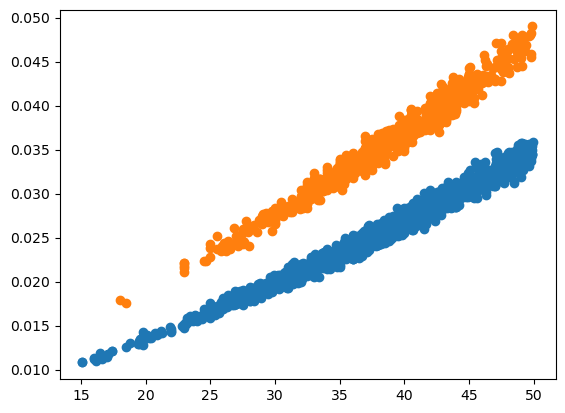

In [20]:
plt.scatter(res_topo_df_no_outliers_vp['t_c'], vp_rho_error)
plt.scatter(res_topo_df_no_outliers_vs['t_c'], vs_rho_error)

calculate total density uncertainty including that part that comes from the temperature-independent part of the density conversion.

In [21]:
# error in density conversion calculation
dens_conv_err_vp = 0.11
dens_conv_err_vs = 0.14
dens_conv_err_no_v = np.sqrt((dens_conv_err_vp**2 + dens_conv_err_vs**2)/2 + 0.08**2)

# get total error including density conversion error
vp_rho_error_total = np.sqrt((vp_rho_error ** 2) + (dens_conv_err_vp ** 2))
vs_rho_error_total = np.sqrt((vs_rho_error ** 2) + (dens_conv_err_vs ** 2))
no_v_rho_error_total = np.sqrt((no_v_rho_error ** 2) + (dens_conv_err_no_v ** 2))


dens_err_all = np.concatenate((vp_rho_error_total, vs_rho_error_total, no_v_rho_error_total))
res_topo_df_no_outliers_all = pd.concat([res_topo_df_no_outliers_vp, 
                                         res_topo_df_no_outliers_vs, 
                                         res_topo_df_no_outliers_no_v], ignore_index=True)

res_topo_df_no_outliers_all['dens_err_all'] = dens_err_all

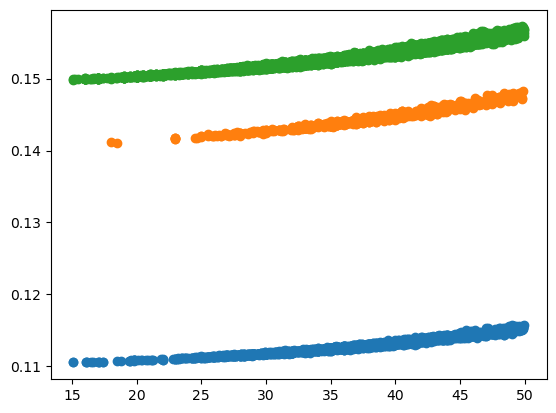

In [22]:
plt.scatter(res_topo_df_no_outliers_vp['t_c'], vp_rho_error_total)
plt.scatter(res_topo_df_no_outliers_vs['t_c'], vs_rho_error_total)
plt.scatter(res_topo_df_no_outliers_no_v['t_c'], no_v_rho_error_total)


Now use crustal density errors to estimate error in residual topography.  Define a function that calculates error in density and thikcness corrections and combines them.

In [23]:
def crust_correction_error(data, error_dict, tcr, rhocr, rhoa):
    """
    Calculate error in correction.  Note if using error in reference and local
    columns, then we need to do this calculation for ref and local columns and
    sum them in quadrature to get combined error.
    Arguments: - data: crustal dataframe with "t_c" and "rho_c" fields.
               - ref_column: reference column used to calculate asthenospehric 
                             structure
               - error_dict: dictionary of uncertainties in parameters
               - adiabat: instance of the adiabat class (can be constant or
                          more complicated but is evaluated as a function of 
                          depth only)
    """

    # get uncertainty terms
    dtc = error_dict["dtc"]
    drhoc = error_dict["drhoc"]
    drhoa = error_dict["drhoa"]

    # get reference and local column values
    tc = np.array(data["t_c"])
    rhoc = np.array(data["rho_c"])
    
    # crust density correction
    dCrhodtc = (rhoc - rhocr) / rhoa
    dCrhodrhoa = tc * ((rhocr - rhoc)/ (rhoa**2))
    dCrhodrhoc = tc/rhoa

    dCrho = np.sqrt((dCrhodtc * dtc)**2 + (dCrhodrhoa * drhoa)**2 + (dCrhodrhoc * drhoc)**2)
    
    # crust thickness correction
    dCtdtc = 1 - (rhocr/rhoa)
    dCtdrhoa = ((tcr - tc) * (rhocr/(rhoa**2)))
    
    dCt = np.sqrt((dCtdtc * dtc)**2 + (dCtdrhoa * drhoa)**2)

    # combine errors
    der = np.sqrt(dCrho**2 + dCt**2)

    return np.column_stack((der, dCrho, dCt))

Plot residual topography error as a function of crustal thickness.

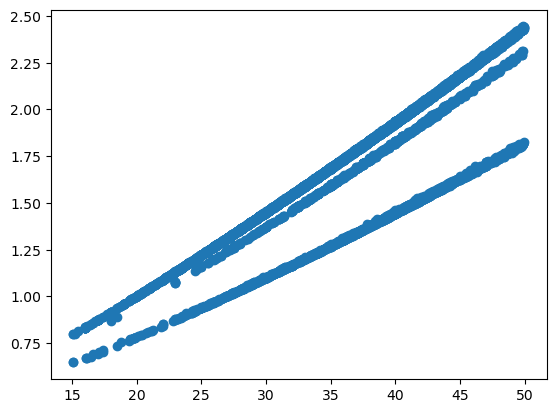

In [24]:
dt_c = 3.0
drho_a = 0.01

obs_param_uncert = {"drhoc": res_topo_df_no_outliers_all["dens_err_all"], 
                    "dtc": dt_c,
                    "drhoa": drho_a}

res_topo_err_all = crust_correction_error(res_topo_df_no_outliers_all, obs_param_uncert, t_cr, rho_cr, rho_a)


res_topo_df_no_outliers_all[['res_topo_err', 'dens_corr_err', 'thickness_corr_err']] = res_topo_err_all

plt.scatter(res_topo_df_no_outliers_all['t_c'], res_topo_err_all[:, 0])

plt.show()

In [25]:
res_topo_df_no_outliers_all.describe().transpose()

count        mean        std         min        25%  \
lon                   19086.0    7.689692  86.579141 -176.684200 -82.416425   
lat                   19086.0   32.910026  25.931883  -67.300000  24.400000   
t_c                   19086.0   36.556342   6.459605   15.100000  32.000000   
vp                     1984.0    6.340032   0.230644    5.335813   6.194095   
vs                      881.0    3.673117   0.128081    3.131515   3.595662   
rho_c                 19086.0    2.867562   0.042194    2.664758   2.839581   
ETOPO                 19086.0    0.602908   0.576944   -0.220658   0.158039   
ETOPO_filt_30km       19086.0    0.607474   0.576508   -0.187711   0.163765   
tl                    19086.0  125.087567  62.252247   27.782981  66.378454   
long_lam_grav         19086.0    5.482087  35.940045 -114.341106 -18.401458   
thickness_correction  19086.0   -0.562185   0.814904   -2.253991  -1.185846   
density_correction    19086.0    0.378221   0.522395   -2.044185  -0.004096   
residual_topography   19086.0    0.423510   0.665838   -2.353755  -0.074628   
mean                  19080.0    0.446168   0.291787    0.007990   0.233557   
std                   19080.0    0.620796   0.108492    0.235832   0.539511   
lower_bound           19080.0   -1.416221   0.600659   -2.608108  -1.831475   
upper_bound           19080.0    2.308557   0.146138    2.078687   2.213268   
lower_bound_smooth    19080.0   -1.413887   0.595561   -2.538223  -1.810244   
upper_bound_smooth    19080.0    2.314454   0.111499    2.131690   2.252316   
dens_err_all          19086.0    0.148450   0.012282    0.110530   0.151454   
res_topo_err          19086.0    1.715631   0.323099    0.646878   1.492033   
dens_corr_err         19086.0    1.671384   0.332534    0.522617   1.443226   
thickness_corr_err    19086.0    0.379049   0.000671    0.378462   0.378529   

                             50%         75%         max  
lon                    13.349135   94.385000  179.952000  
lat                    39.570401   49.097016   82.503300  
t_c                    36.898788   41.500000   49.967000  
vp                      6.342371    6.502836    6.966501  
vs                      3.693822    3.767953    3.956223  
rho_c                   2.867723    2.894523    3.109107  
ETOPO                   0.389755    0.930260    3.297661  
ETOPO_filt_30km         0.394552    0.934009    3.272673  
tl                    115.065170  176.780344  283.522806  
long_lam_grav           3.330407   30.829667  120.655714  
thickness_correction   -0.605386    0.012615    2.144615  
density_correction      0.315616    0.704609    4.003236  
residual_topography     0.360945    0.840305    2.891487  
mean                    0.411780    0.539692    1.983977  
std                     0.634504    0.688332    0.873541  
lower_bound            -1.520813   -1.078841    1.035888  
upper_bound             2.290133    2.401480    3.129130  
lower_bound_smooth     -1.536246   -1.083719    0.871161  
upper_bound_smooth      2.322453    2.350336    3.044801  
dens_err_all            0.152530    0.153734    0.157245  
res_topo_err            1.710894    1.955718    2.443701  
dens_corr_err           1.668485    1.918617    2.413742  
thickness_corr_err      0.378794    0.379396    0.381498

### Save files

Save file, noting the numebrs of the columns for some of the key parameters.  Remove extraneous columns from the database that are not bnecessary to save.

In [26]:
columns_to_drop = ['lower_bound', 'upper_bound', 'lower_bound_smooth', 'upper_bound_smooth', 'mean', 'std']
res_topo_df_to_save = res_topo_df_no_outliers_all.drop(columns=columns_to_drop)

# print column numbers of the things we want to plot
print(f"Station name column: {res_topo_df_to_save.columns.get_loc('station') + 1}")
print(f"Longitude column: {res_topo_df_to_save.columns.get_loc('lon') + 1}")
print(f"Latitude column: {res_topo_df_to_save.columns.get_loc('lat') + 1}")
print(f"Residual topography column: {res_topo_df_to_save.columns.get_loc('residual_topography') + 1}")
print(f"Residual topography error column: {res_topo_df_to_save.columns.get_loc('res_topo_err') + 1}")
print(f"Crust thickness column: {res_topo_df_to_save.columns.get_loc('t_c') + 1}")


Station name column: 1
Longitude column: 2
Latitude column: 3
Residual topography column: 14
Residual topography error column: 16
Crust thickness column: 4


In [27]:
output_file_csv = "../OUTPUT_DATA_T_DEPENDENT/crust_only.csv"
output_file_dat = "../OUTPUT_DATA_T_DEPENDENT/crust_only.dat"

res_topo_df_to_save.to_csv(output_file_csv, sep=',', index=False, na_rep='NaN')
res_topo_df_to_save.to_csv(output_file_dat, sep=' ', index=False, na_rep='NaN')


In [28]:
res_topo_df_to_save[(res_topo_df_to_save['lat'] >= 39) & (res_topo_df_to_save['lat'] <= 44) & (res_topo_df_to_save['lon'] >= 39) & (res_topo_df_to_save['lon'] <= 50)]


station    lon    lat   t_c        vp  vs     rho_c     ETOPO  \
1563   ID2062  45.91  43.55  43.4  6.281106 NaN  2.964619  0.052304   
1864   ID2061  45.91  43.10  47.4  6.217300 NaN  2.929371  0.294360   
16654     NaN  45.91  43.55  43.4       NaN NaN  2.901610  0.052304   
18536     NaN  45.91  43.10  47.4       NaN NaN  2.919396  0.294360   

       ETOPO_filt_30km          tl  long_lam_grav  thickness_correction  \
1563          0.054164  187.433622       2.245012             -1.425538   
1864          0.378045  171.580572      11.525391             -1.930154   
16654         0.054164  187.433622       2.245012             -1.425538   
18536         0.378045  171.580572      11.525391             -1.930154   

       density_correction  residual_topography  dens_err_all  res_topo_err  \
1563             1.664140             0.292766      0.114036      1.573660   
1864             1.303440            -0.248670      0.114711      1.717764   
16654            0.822734            -0.548640      0.154461      2.098080   
18536            1.157961            -0.394148      0.155934      2.307042   

       dens_corr_err  thickness_corr_err  
1563        1.527170            0.379679  
1864        1.675048            0.380691  
16654       2.063440            0.379679  
18536       2.275416            0.380691